In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.cm as cm

import scipy
import scipy.cluster.hierarchy as sch
import time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

from IPython.core.display import display, HTML
from datetime import datetime, timedelta

pd.set_option('display.float_format', '{:.5g}'.format)

def getKey(item):
    return item[0]


def addAtt(data,key,value):
    data[key] = value
    return data

In [2]:
nameFile = '1min.txt'
freqGlobal = "1min"
nameExperiment = nameFile.split('.')[0]
modWriteFileExp = 'w'
#modWriteFileExp = 'a'

In [3]:
def my_test(date, time):
    strTest = str(time)
    testLen=len(strTest)
    dateTem = str(date)+(6-(testLen))*'0'+strTest
    
    t = dateTem
    outTimestamp = t[:4]+'-'+t[4:6]+'-'+t[6:8]+' '+t[8:10]+':'+t[10:12]+':'+t[12:14]
    return outTimestamp

def getDataToProcess(fileDir):
    dataOut = pd.read_csv(fileDir,
                     delimiter=',',
                     decimal='.',
                     header=None)
    df = dataOut[[2,3,7]]

    df['time'] = df.apply(lambda row: my_test(row[2], row[3]), axis=1)
    del df[2] 
    del df[3]
    df = df.drop(df.index[[0]])
    df['price'] = pd.to_numeric(df[7], downcast='float')
    del df[7]
    df.index = pd.to_datetime(df['time'])
    del df['time']
    return df

In [4]:
def fillData(dataOut):
    data = []
    dfDays = dataOut.groupby(pd.Grouper(freq='D'))
    global freqGlobal
    for dateD,groupD in dfDays:
        if(groupD.shape[0] > 0):
            init = groupD.head(1).index[0]
            end = groupD.tail(1).index[0]
            if(init.weekday() <= 4):
                dates = pd.date_range(init, end, freq=freqGlobal)
                
                dfTem = pd.DataFrame(index=dates, columns=['price'])
                dfTem['price'] = groupD['price']
                dfTem=dfTem.fillna(method='ffill').fillna(method='bfill')
                data.append(dfTem)
    df=pd.concat(data)
    return df

In [5]:
dirr = 'datosMuestra/'+nameFile
dataProcess1 = getDataToProcess(dirr)
df1 = fillData(dataProcess1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
print(df1.head(2))
print(df1.tail(2))

                     price
2017-08-01 01:01:00  50.16
2017-08-01 01:02:00  50.16
                     price
2018-07-31 23:59:00   68.4
2018-08-01 00:00:00  68.43


In [7]:
df1.shape

(365247, 1)

In [8]:
#groups=['6M','4M','3M','2M','1M','3W']

In [9]:
#file = open("datosMuestraFiltrados/index.txt","w") 
#for g in groups:
#    dfGroup = df1.groupby(pd.Grouper(freq=g))
#    lenGroup=str(len(dfGroup.size()))
#    for i,(dateD,groupD) in enumerate(dfGroup):
#        limit=int(groupD.shape[0]*float(0.7))
#        train = groupD.iloc[:limit]
#        test = groupD.iloc[limit:]
#        train.to_csv('datosMuestraFiltrados/train_'+g+'_'+str(i)+'_'+lenGroup+'.csv', sep='\t', header=None)
#        test.to_csv('datosMuestraFiltrados/test_'+g+'_'+str(i)+'_'+lenGroup+'.csv', sep='\t', header=None)
#        file.write('_'+g+'_'+str(i)+'_'+lenGroup+'\n')
#file.close() 

In [10]:
#groups=[['1M',4,2],['1M',3,1],['1M',2,1],['1W',5,3],['1W',6,2],['1W',3,1],['1W',2,1]]
#['1D',5,3],['1D',5,2],['1D',4,2],['1D',4,3],['1D',3,2],['1D',3,1],
groups=[['1D',2,1]]

In [11]:
file = open("datosMuestraFiltrados/index.txt",modWriteFileExp) 
for g in groups:
    dfGroup = df1.groupby(pd.Grouper(freq=g[0]))
    lenGroup=str(len(dfGroup.size()))
    buffer=[]
    buffer2=[]
    for i,(dateD,group) in enumerate(dfGroup):
        buffer.append(group)
        buffer2.append(i)
        if(len(buffer) >= g[1]+g[2]):
            print()
            #print(buffer2[:g[1]])
            #print(buffer2[g[1]:])
            
            
            train=pd.concat(buffer[:g[1]])
            test=pd.concat(buffer[g[1]:])
            
            if(test.shape[0]>0 and train.shape[0]>0):
                print(buffer2[:g[1]])
                print(buffer2[g[1]:])
                print(g)    
                print(train.shape)
                print(test.shape)
                cred = g[0]+'_'+str(g[1])+'_'+str(g[2])
                name = '_'+cred+'_'+str(i)+'_'+lenGroup+'_'+nameExperiment
                train.to_csv('datosMuestraFiltrados/train'+name+'.csv', sep='\t', header=None)
                test.to_csv('datosMuestraFiltrados/test'+name+'.csv', sep='\t', header=None)
                file.write(name+'\n')
            del buffer[0]
            del buffer2[0]
file.close() 


[0, 1]
[2]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[1, 2]
[3]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[5, 6]
[7]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[6, 7]
[8]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[7, 8]
[9]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[8, 9]
[10]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[12, 13]
[14]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[13, 14]
[15]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[14, 15]
[16]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[15, 16]
[17]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[19, 20]
[21]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[20, 21]
[22]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[21, 22]
[23]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[22, 23]
[24]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[26, 27]
[28]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[27, 28]
[29]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[28, 29]
[30]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[29, 30]
[31]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[33, 34]
[35]
['1D', 2, 1]
(1141, 1)
(1379, 1)

[34, 35]
[36]
['1D', 2, 1]
(2520, 1)
(1440, 1)

[35, 36]
[37]
['1D', 2, 1]
(2819, 1)
(144


[288, 289]
[290]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[292, 293]
[294]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[293, 294]
[295]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[294, 295]
[296]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[295, 296]
[297]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[299, 300]
[301]
['1D', 2, 1]
(1140, 1)
(1379, 1)

[300, 301]
[302]
['1D', 2, 1]
(2519, 1)
(1440, 1)

[301, 302]
[303]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[302, 303]
[304]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[306, 307]
[308]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[307, 308]
[309]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[308, 309]
[310]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[309, 310]
[311]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[313, 314]
[315]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[314, 315]
[316]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[315, 316]
[317]
['1D', 2, 1]
(2880, 1)
(1440, 1)

[316, 317]
[318]
['1D', 2, 1]
(2880, 1)
(1440, 1)




[320, 321]
[322]
['1D', 2, 1]
(1379, 1)
(1440, 1)

[321, 322]
[323]
['1D', 2, 1]
(2819, 1)
(1440, 1)

[322, 323]
[324

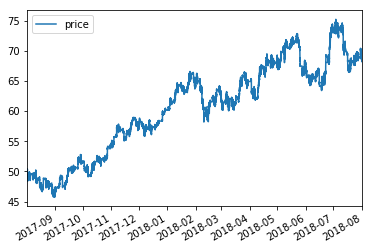

In [12]:
df1.plot()